Things to do:
    
- Fix the `CustomNeuron` class
- Plot results for different parameters

In [11]:
from utils import get_binary_mnist_dataloaders

from fastprogress.fastprogress import master_bar, progress_bar

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from jupyterthemes import jtplot

jtplot.style(context="talk")

In [12]:
data_path = "../data"
classA = 1
classB = 8

full_train_loader, _, _, _ = get_binary_mnist_dataloaders(
    data_path, classA, classB, 0, 0
)

In [13]:
deviations = torch.std(full_train_loader.dataset.data, dim=0)
max_dev_row = deviations.sum(dim=1).argmax()
max_dev_row

tensor(9)

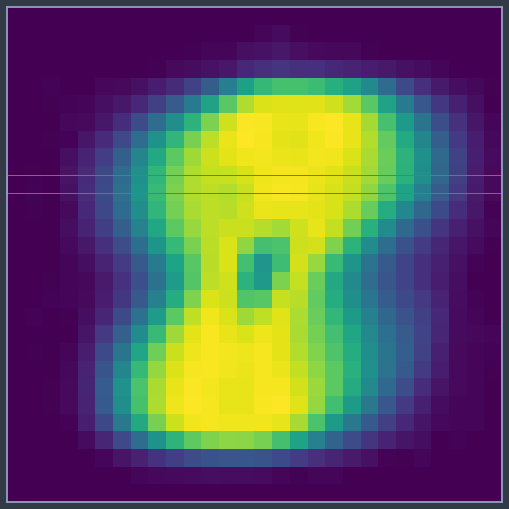

In [14]:
_, ax = plt.subplots()
ax.imshow(deviations)

xmin, xmax = ax.get_xlim()

rect = patches.Rectangle(
    (xmin, max_dev_row), 28, 1, linewidth=1, edgecolor="r", facecolor="none"
)
ax.add_patch(rect)
ax.grid(None)
ax.set_xticklabels([])
ax.set_yticklabels([]);

In [15]:
class CustomNeuron(nn.Module):
    def __init__(self, layer_sizes):
        super(CustomNeuron, self).__init__()
        # The network should assume that the model input is (28 pixels) and
        # that there is one output neuron
        self.layers = nn.Sequential(nn.Linear(28, 1), nn.Sigmoid())

    def forward(self, X):
        # The X value is (N, 28, 28)
        modified_X = X[:, 9, :]
        return self.layers(modified_X)

In [16]:
X = full_train_loader.dataset.data
# X[:, 9, :].shape
torch.all(X.view(-1, 784)[:, 9*28:9*28+28] == X[:, 9, :])

tensor(True)

In [17]:
def train_one_epoch(
    dataloader, model, criterion, learning_rate, weight_decay, momentum, device, mb
):

    if not hasattr(model, "momentum_grads"):
        model.momentum_grads = [torch.zeros_like(p) for p in model.parameters()]

    model.train()

    num_batches = len(train_loader)
    dataiter = iter(dataloader)

    for batch in progress_bar(range(num_batches), parent=mb):

        X, Y = next(dataiter)
        X, Y = X.to(device), Y.to(device)

        output = model(X)

        loss = criterion(output, Y)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param, grad in zip(model.parameters(), model.momentum_grads):
                grad.set_(momentum * grad + (1 - momentum) * param.grad)
                param -= learning_rate * grad + weight_decay * param

In [18]:
def compute_validation_accuracy(dataloader, model, criterion, device, mb, epoch):

    model.eval()

    N = len(dataloader.dataset)
    num_batches = len(dataloader)

    valid_loss, num_correct = 0, 0

    with torch.no_grad():

        for X, Y in dataloader:

            X, Y = X.to(device), Y.to(device)
            output = model(X)

            valid_loss += criterion(output, Y).item()
            num_correct += (output.round().eq(Y)).type(torch.float).sum().item()

        valid_loss /= num_batches
        valid_accuracy = num_correct / N

    mb.write(
        f"{epoch:>3}: validation accuracy={(100*valid_accuracy):5.2f}% and loss={valid_loss:.3f}"
    )
    return valid_loss, valid_accuracy

In [19]:
# Configuration parameters
seed = 0
torch.manual_seed(seed)

# Hyperparameters
num_epochs = 4
batch_size = 128
valid_batch_size = 0

learning_rate = 1e-2
weight_decay = 0#1e-3
momentum = 0#0.9

# Training device
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

Using 'cpu' device.


In [20]:
# Get data loaders
train_loader, _, valid_loader, _ = get_binary_mnist_dataloaders(
    data_path, classA, classB, batch_size, valid_batch_size
)

In [27]:
# Create neural network model
nx = train_loader.dataset.data.shape[1:].numel()
ny = 1
layer_sizes = (nx, ny)

model = CustomNeuron(layer_sizes).to(device)
print(model)

# Training utilities
criterion = nn.L1Loss()

CustomNeuron(
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [22]:
# Training loop
mb = master_bar(range(num_epochs))
compute_validation_accuracy(valid_loader, model, criterion, device, mb, 0)
for epoch in mb:
    train_one_epoch(
        train_loader,
        model,
        criterion,
        learning_rate,
        weight_decay,
        momentum,
        device,
        mb,
    )
    tloss, taccuracy = compute_validation_accuracy(
        valid_loader, model, criterion, device, mb, epoch + 1
    )

In [28]:
w_index = 14

w_orig = model.layers[0].weight[0][w_index].item()
l_orig = tloss
a_orig = taccuracy

w_values = torch.linspace(w_orig - 15, w_orig + 15, 100)

losses = []
accuracies = []

device = "cpu"
model.to(device)

with torch.no_grad():
    for w in progress_bar(w_values):
        model.layers[0].weight[0][w_index] = w
        loss, accuracy = compute_validation_accuracy(
            valid_loader, model, criterion, device, mb, 0
        )
        losses.append(loss)
        accuracies.append(accuracy)

    # Fix the changed parameter
    model.layers[0].weight[0][w_index] = w_orig

Text(0.5, 1.0, 'Parameter vs Loss')

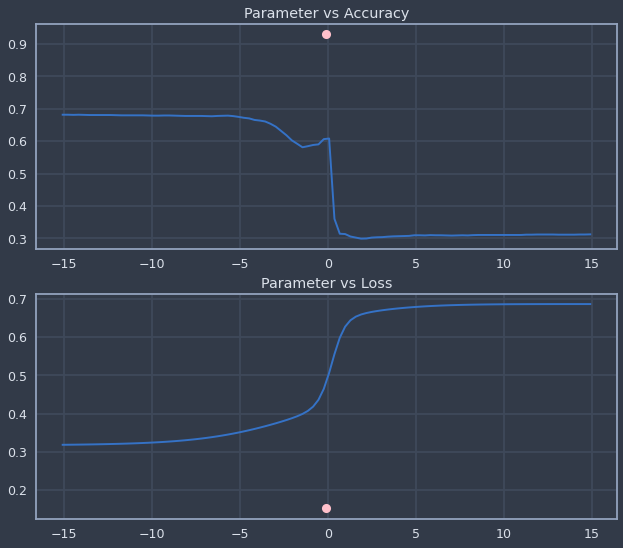

In [29]:
_, axes = plt.subplots(2, 1)
axes[0].plot(w_values, accuracies)
axes[0].plot(w_orig, a_orig, "o", color="pink")
axes[0].set_title("Parameter vs Accuracy")
axes[1].plot(w_values, losses)
axes[1].plot(w_orig, l_orig, "o", color="pink")
axes[1].set_title("Parameter vs Loss")